# FUNCTIONS

In [ ]:
# !gdown --id '1xYbIkdUR_XYKYE868EltaqZJAcPH-7Cv' # 下載資料集
# !unzip hidden.zip -d ./data
# !git clone https://github.com/Line233/one.git ./one
# !mv ./one/tool.py ./

In [ ]:
# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
import torch
import random
import torchvision
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import torch.utils.data as data
import torch.nn as nn
import tool
%matplotlib inline
import importlib
importlib.reload(tool)
import os

In [ ]:
class mnist_data(data.Dataset):
    def __init__(self,x,y):
        self.x=x.float()
        self.y=y.long()
    def __len__(self):
        return len(self.x)
    def __getitem__(self,index):
        if self.y is not None:
            return self.x[index].reshape([-1]),self.y[index].long()
        else:
            return self.x[index].reshape([-1])

In [ ]:
class mnist_single(nn.Module):
    def __init__(self,input_a,hidden_a,device=torch.device('cpu'),rand_seed=10):
        super(mnist_single,self).__init__()
        torch.manual_seed(rand_seed)
        self.device=device
        self.hidden_a=hidden_a
        self.linear1=nn.Linear(input_a,self.hidden_a)
        self.relu=nn.ReLU()
        self.linear2=nn.Linear(self.hidden_a,10)
        self.softmax=nn.Softmax(dim=1)
        self.lossF=nn.CrossEntropyLoss()
    def forward(self,input):
        input=input.to(self.device)
        res=self.linear1(input)
        res=self.relu(res)
        res=self.linear2(res)
        res=self.softmax(res)
        return res

    def expand(self):
        new_linear=nn.Linear(self.linear1.in_features,self.linear1.out_features+1).to(self.device)
        new_linear2=nn.Linear(self.linear2.in_features+1,self.linear2.out_features).to(self.device)
        with torch.no_grad():
            # weight=np.zeros([self.linear1.out_features])
            # for i in range(self.linear1.out_features):
            #     weight[i]=abs(self.linear1.weight.data[i]*self.linear2.weight.data[:,i])
            index=0

            weight=self.__expand_weight_down__(self.linear1.weight.data.detach(),index)
            bias=self.__expand_weight_down__(self.linear1.bias.data.detach(),index)
            new_linear.weight.data=weight
            new_linear.bias.data=bias

            weight2=self.__expand_weight_up__(self.linear2.weight.data.detach(),index)
            new_linear2.weight.data=weight2

        self.linear1=new_linear.to(self.device)
        self.linear2=new_linear2.to(self.device)
        return

    def __expand_weight_up__(self,weight,index):
        with torch.no_grad():
            shape=torch.tensor(weight.shape)
            shape[1]=1
            # new_weight=weight.data[:,index].reshape(shape.tolist()).clone()*0.4
            # new_weight=torch.zeros(shape.tolist()).to(self.device)+0.001
            # new_weight=torch.normal(0,0.05,shape.tolist()).to(self.device)
            # new_weight=torch.sum(weight,dim=1).reshape(shape.tolist()).to(self.device)
            std_mean=torch.std_mean(weight,dim=1)
            new_weight=torch.normal(std_mean[1],std_mean[0]).reshape(shape.tolist()).to(self.device)
            weight.data[:,index]*=1
            new_weight=torch.cat([weight,new_weight],dim=1)
            new_weight/=new_weight.shape[1]
        return new_weight

    def __expand_weight_down__(self,weight,index):
        with torch.no_grad():
            shape=torch.tensor(weight.shape)
            shape[0]=1
            # new_weight=weight[index].reshape(shape.tolist()).clone()*0.4
            # new_weight=torch.zeros(shape.tolist()).to(self.device)+0.001
            # new_weight=torch.normal(0,0.05,shape.tolist()).to(self.device)
            # new_weight=torch.sum(weight,dim=0).reshape(shape.tolist()).to(self.device)/weight.shape[0]
            std_mean=torch.std_mean(weight,dim=0)
            new_weight=torch.normal(std_mean[1],std_mean[0]).reshape(shape.tolist()).to(self.device)
            weight.data[index]*=1
            new_weight=torch.cat([weight,new_weight],dim=0)
        return new_weight
    
    def reset_loss_record(self):
        self.__total_loss__=0.0
        self.__right_num__=0
        self.__total_num__=0
    def computeloss(self,x,y,res):
        y=y.to(self.device)
        loss=self.lossF(res,y)
        self.__total_loss__+=loss.tolist()*len(x)
        a=res.argmax(dim=1)
        self.__right_num__+=torch.eq(a,y).sum().tolist()
        self.__total_num__+=len(x)
        return loss
    def get_loss(self):
        return self.__total_loss__/self.__total_num__,self.__right_num__/self.__total_num__

In [ ]:
class mnist_cov(nn.Module):
    def __init__(self,input_a,input_channel,device=torch.device('cpu'),rand_seed=10):
        super(mnist_cov,self).__init__()
        torch.manual_seed(rand_seed)
        self.device=device
        self.inputa=input_a
        self.input_channel=input_channel

        self.out=nn.Sequential(
            nn.Conv2d(1,4,3,1,1),
            nn.MaxPool2d(3,2),
            nn.Conv2d(4,16,3,1,1),
            nn.MaxPool2d(3,2)
        )
        self.out2=nn.Sequential(
            nn.Linear(16,10),
            nn.Softmax(dim=1)
        )
        self.lossF=nn.CrossEntropyLoss()
        pass
    def forward(self,input):
        input=input.reshape([-1,self.input_channel,self.inputa,self.inputa]).to(self.device)
        res=self.out(input)
        res= res.reshape([-1,16])
        res=self.out2(res)
        return res
    def reset_loss_record(self):
        self.__total_loss__=0.0
        self.__right_num__=0
        self.__total_num__=0
    def computeloss(self,x,y,res):
        y=y.to(self.device)
        loss=self.lossF(res,y)
        self.__total_loss__+=loss.tolist()*len(x)
        a=res.argmax(dim=1)
        self.__right_num__+=torch.eq(a,y).sum().tolist()
        self.__total_num__+=len(x)
        return loss
    def get_loss(self):
        return self.__total_loss__/self.__total_num__,self.__right_num__/self.__total_num__

In [ ]:
# def early_end(records,last,mini=1000,step=200,bias=0):
#     if len(records)-last<mini:
#         return False
#     elif records[-step][2]-records[-1][2]-bias>0:
#         return False
#     else:return True
# def dlr1(index):
#     # return max(pow(0.1,index+3),pow(0.1,5))
#     return 0.001

In [ ]:
def download_out():   
    !zip -vr out.zip  ./out/
    tool.download('out.zip') 

In [ ]:
def count(dataset,num):
    arr=np.ones(10)
    res=[]
    i=0
    total=0
    while True:
        k=int(dataset[i])
        if arr[k]<=num:
            res.append(i)
            arr[k]+=1
            total+=1
        if total==num*10:
            break
        i+=1
    return res

In [ ]:
def count_set(dataset,num):
    res=count(dataset.y,num)
    return mnist_data(dataset.x[res],dataset.y[res])

# DATA

In [ ]:
version=217
batch_size=128
epoch=1000
epoch_per=1
lr=0.001
hidden=10
ee_mini=40
ee_step=20
ee_bias=0
shot=5

In [ ]:
train_data=torch.load('./data/train_hidden')
valid_data=torch.load('./data/valid_hidden')
test_data=torch.load('./data/test_hidden')

In [ ]:
train_data=count_set(train_data,shot)

In [ ]:
simple_data=mnist_data(valid_data[0:100][0].reshape([-1,10,10]),valid_data[0:100][1])

In [ ]:
device=torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
torch.tensor([1,2]).to(device)
labels=['train_loss','train_precise','valid_loss','valid_precise']
select_loss=[True,False,True,False]
select_precise=[False,True,False,True]
folder_out='./out/'

In [ ]:
def out_name(version,name):
    return  f'{folder_out}{version:04}/{name}'
if not os.path.exists(out_name(version,'')):
    os.makedirs(out_name(version,''))

In [ ]:
def early_end(records,last,mini=ee_mini,step=ee_step,bias=ee_bias):
    if len(records)-last<mini:
        return False
    elif records[-step][2]-records[-1][2]-bias>0:
        return False
    else:return True
def dlr1(index):
    # return max(pow(0.1,index+3),pow(0.1,5))
    return 0.001

# TRAIN_CONV

In [ ]:
model=mnist_cov(10,1,device).to(device)
record1=[]

In [ ]:
record1+=tool.TrainTool.train_epoch(model,simple_data,valid_data,lr=0.0001,batch_size=1000,epoch=10)

In [ ]:
lc1=tool.learning_curve(record1,reshape=True)
lc1.save('./data/conv_lc.npy')

# TRAIN_SINGLE

In [ ]:
model_single=mnist_single(100,hidden,device=device).to(device)
res=[]
optim=torch.optim.Adam(model_single.parameters(),lr=lr)

In [ ]:
f=tool.TrainTool.train_epoch(model_single,train_data,valid_data,res,lr=lr,batch_size=batch_size,epoch=epoch,epoch_per=epoch_per,optim=optim)

In [ ]:
single_lc=tool.learning_curve(res,labels,reshape=True)

In [ ]:
single_lc.save(out_name(version,'single_s_lc.npy'))
torch.save(model_single,out_name(version,'single_s_model'))

In [ ]:
single_lc.draw(select=select_precise)

# ADAM_RESET

In [ ]:
ar_model=mnist_single(100,hidden,device).to(device)
ar_record=[]
ar_reset=[]

In [ ]:
f=tool.TrainTool.train_adam_reset(ar_model,train_data,valid_data,ar_record,ar_reset,dlr=dlr1,batch_size=batch_size,epoch=epoch,epoch_per=epoch_per,early_end=early_end)


In [ ]:
ar_lc=tool.learning_curve(ar_record,reshape=True)
ar_lc.add_vlines(ar_reset)

In [ ]:
ar_lc.save(out_name(version,'ar_lc.npy'))
torch.save(ar_model,out_name(version,'ar_model'))

In [ ]:
ar_lc.draw()

# EXPAND

In [ ]:
ex_model=mnist_single(100,hidden,device).to(device)
ex_record=[]
ex_ex=[]

In [ ]:
f=tool.TrainTool.train_expand(ex_model,train_data,valid_data,ex_record,ex_ex,dlr=dlr1,batch_size=batch_size,epoch=epoch,epoch_per=epoch_per,early_end=early_end)

In [ ]:
ex_lc=tool.learning_curve(ex_record,reshape=True)
ex_lc.add_vlines(ex_ex)

In [ ]:
ex_lc.save(out_name(version,'ex_lc.npy'))
torch.save(ex_model,out_name(version,'ex_model'))

In [ ]:
ex_lc.draw(select=select_precise)

In [ ]:
ex_model

In [ ]:
ex_lc.draw_range(block_num=1,select=select_precise)

# LEARNING_CURVE

ex_lc

In [ ]:
ex_lc=tool.learning_curve.load2(out_name(version,'ex_lc.npy'),['ex_'+label[:-8] for label in labels],title='ex')

In [ ]:
ex_lc.draw(select=select_precise)

compare

In [148]:
# single_s_lc=tool.learning_curve.load2(out_name(version,'single_s_lc.npy'),['s_'+label[:-8] for label in labels],title='single')
# single_e_lc=tool.learning_curve.load2(out_name(version,'single_e_lc.npy'),['e_'+label[:-8] for label in labels],title='single')
# # ar_lc=tool.learning_curve.load2(out_name(version,'ar_lc.npy'),['ar_'+label[:-8] for label in labels],title='ar')
ex_lc2=tool.learning_curve.load2(out_name(version,'ex_lc.npy'),['ex217_'+label[:-8] for label in labels],title='ex')
ex_lc=tool.learning_curve.load2(out_name(216,'ex_lc.npy'),['ex216_'+label[:-8] for label in labels],title='ex')

compare_lc=tool.learning_curve([])
compare_lc.add_curve(
    [
        # single_s_lc[1],
        # single_e_lc[1],
        ex_lc[1],
        ex_lc2[1],
        # ar_lc[1],
        # single_s_lc[3],
        # single_e_lc[3],
        ex_lc[3],
        ex_lc2[3]
        # ar_lc[3]
    ]
    )
compare_lc.add_vlines(ex_lc2.vlines)
# compare_lc.add_vlines(ex_lc.vlines)

0


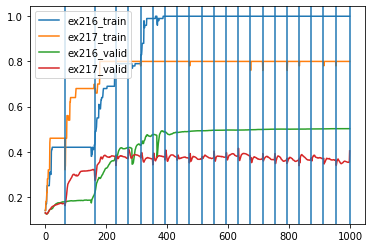

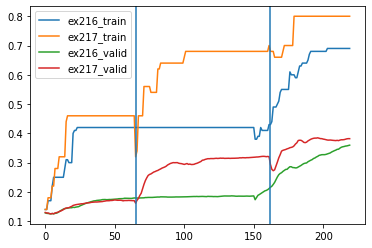

1


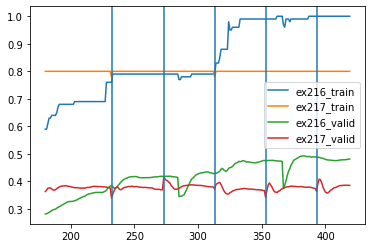

2


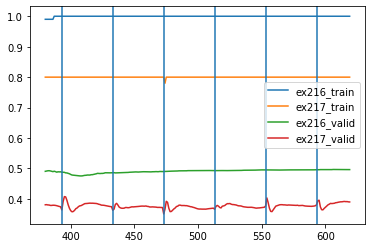

3


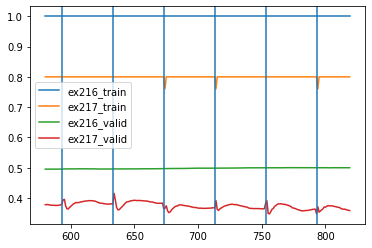

4


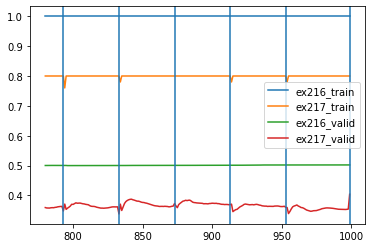

[<Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>,
 <Figure size 432x288 with 1 Axes>]

In [149]:
compare_lc.draw()
compare_lc.draw_range(block_num=5,expand=20)

In [ ]:
ex_lc.draw_range(block_num=10,expand=20,select=[0,0,1,0])

linear_weight

In [ ]:
a=10
b=a+3
w_lc=tool.learning_curve(ex_model.linear1.weight.data[a:b],title=f'ex_linear1[{a}-{b}]')
w_lc.draw()

# DOWNLOAD

In [ ]:
tool.colab_tool.zip('out','./out/')

In [ ]:
tool.colab_tool.download_drive(['out.zip'])


In [ ]:
tool.colab_tool.download(['out_zip'])

In [ ]:
function ClickConnect() {
  console.log('Working')
  document
    .querySelector('#top-toolbar > colab-connect-button')
    .shadowRoot.querySelector('#connect')
    .click()
}

setInterval(ClickConnect, 60000)

In [ ]:
# function ClickConnect() {
#   console.log('Working')
#   document
#     .querySelector('#top-toolbar > colab-connect-button')
#     .shadowRoot.querySelector('#connect')
#     .click()
# }
# var numberOfTimes = 3;
# delay = 1000*60*50;

# for (let i = 0; i < numberOfTimes; i++) {
#     setTimeout( doSomething, delay * i);
# }

In [ ]:
a=torch.tensor([[1,3],[2,4]],dtype=float)

In [ ]:
torch.mean(a,dim=0)

In [ ]:
torch.std_mean(a,dim=0)